# Model training

David René Langarica Hernández | A01708936

In [18]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.19.0


In [19]:
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255, 
                                    rotation_range = 20,
                                    width_shift_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (200, 200),
    batch_size = 32,
    class_mode ='categorical',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (200, 200),
    batch_size = 32,
    class_mode ='categorical',
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (200, 200),
    batch_size = 32,
    class_mode ='categorical',
)

Found 15120 images belonging to 7 classes.
Found 4200 images belonging to 7 classes.
Found 1680 images belonging to 7 classes.


In [21]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

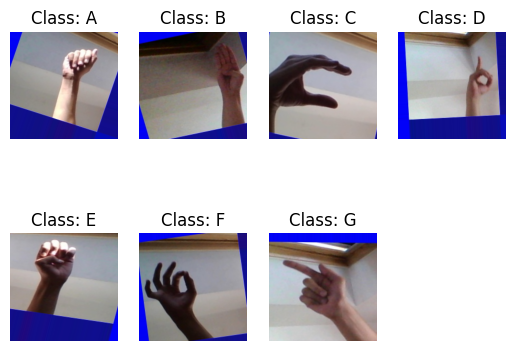

In [22]:
class_examples = {}
num_classes = len(class_names) 

while len(class_examples) < num_classes:
    images, labels = next(train_generator)
    for i in range(len(images)):
        class_idx = np.argmax(labels[i])
        if class_idx not in class_examples and class_idx < num_classes:
            class_examples[class_idx] = images[i]
    
    if len(class_examples) == num_classes:
        break


plt.figure()

for i, class_idx in enumerate(sorted(class_examples.keys())):
    plt.subplot(2, 4, i + 1)
    plt.imshow(class_examples[class_idx])
    plt.title(f'Class: {class_names[class_idx]}')
    plt.axis('off')

plt.show()

In [23]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
])


In [24]:
model.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics=['accuracy'])

In [25]:
history = model.fit(train_generator, 
        epochs=5,
        validation_data=validation_generator)

Epoch 1/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 275s 577ms/step - accuracy: 0.2300 - loss: 2.0522 - val_accuracy: 0.6571 - val_loss: 0.9810
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 259s 546ms/step - accuracy: 0.5557 - loss: 1.1750 - val_accuracy: 0.6923 - val_loss: 0.9862
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 258s 544ms/step - accuracy: 0.6862 - loss: 0.8416 - val_accuracy: 0.8190 - val_loss: 0.5598
Epoch 4/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 257s 543ms/step - accuracy: 0.7680 - loss: 0.6320 - val_accuracy: 0.8018 - val_loss: 0.6596
Epoch 5/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 262s 554ms/step - accuracy: 0.8245 - loss: 0.4836 - val_accuracy: 0.7935 - val_loss: 0.7807


In [26]:
test_loss, test_acc = model.evaluate(test_generator)

print('\nTest accuracy:', test_acc)

132/132 ━━━━━━━━━━━━━━━━━━━━ 55s 413ms/step - accuracy: 0.6837 - loss: 1.2999

Test accuracy: 0.6845238208770752
